# Pre-trained model

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip /content/140k-real-and-fake-faces.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

C:\Users\sanya\AppData\Local\Temp\ipykernel_12772\3121535740.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12700210216607598482
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14404894421804374041
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [5]:
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [6]:
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100

In [7]:
generator = load_model("models/generator.keras")

generator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

In [8]:
# Generating the fake images training data from the generator
def save_fake(output_dir,num_images=1000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    generated_images = generator.predict(tf.random.normal((num_images, latent_features, 1)),verbose=0)

    for i in range(num_images):
        image = generated_images[i]
        image = (image + 1) / 2
        image_path = os.path.join(output_dir, f"{i}.jpg")
        tf.keras.preprocessing.image.save_img(image_path, image)

    print(f"{i + 1} images generated and saved to {output_dir}.")

save_fake("resnet_data/train/0",num_images=800)
save_fake("resnet_data/valid/0",num_images=200)
save_fake("resnet_data/test/0",num_images=500)

800 images generated and saved to resnet_data/train/0.
200 images generated and saved to resnet_data/valid/0.
500 images generated and saved to resnet_data/test/0.


In [9]:
# Saving the real images in a different directory
def save_real(source_dir, destination_dir, num_images=1000):
    real_folder = os.path.join(source_dir, 'real')
    image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)]

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    image_counter = 0
    for i, file_path in enumerate(image_paths):
        with Image.open(file_path) as img:
            output_path = os.path.join(destination_dir, f"{i}.jpg")
            img.save(output_path)
            image_counter += 1
        if image_counter >= num_images:
                break
    print(f"{num_images} images saved from {source_dir}to {destination_dir}.")

save_real('real_vs_fake/real-vs-fake/train', "resnet_data/train/1", num_images=800)
save_real('real_vs_fake/real-vs-fake/valid', "resnet_data/valid/1", num_images=200)
save_real('real_vs_fake/real-vs-fake/test', "resnet_data/test/1", num_images=500)

800 images saved from real_vs_fake/real-vs-fake/trainto resnet_data/train/1.
200 images saved from real_vs_fake/real-vs-fake/validto resnet_data/valid/1.
500 images saved from real_vs_fake/real-vs-fake/testto resnet_data/test/1.


In [10]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/train",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 1600 files belonging to 2 classes.


In [11]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/valid",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 400 files belonging to 2 classes.


In [12]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/test",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 1000 files belonging to 2 classes.


In [13]:
def augument(x, y):
    img = tf.cast(x, tf.float32)
    img = (img - 127.5) / 127.5
    return img, y

In [14]:
train_dataset = train_dataset.map(augument)
valid_dataset = valid_dataset.map(augument)
test_dataset = test_dataset.map(augument)

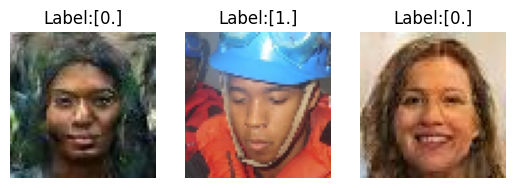

In [15]:
for batch, labels in train_dataset.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

## Convolutional neural network

In [16]:
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet_clf = Model(inputs=base_model.input, outputs=predictions)
resnet_clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [18]:
model_save_dir = 'models/resnet_clf_cp.h5'
if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

save_callback = ModelCheckpoint(model_save_dir
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)

resnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])

In [19]:
tf.keras.backend.clear_session()
resnet_clf_history = resnet_clf.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[save_callback],
    use_multiprocessing=True
)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block5c_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\sanya\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sanya\AppData\Local\Temp\ipykernel_12772\1688798161.py", line 2, in <module>
      resnet_clf_history = resnet_clf.fit(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/block5c_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[256,672,4,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block5c_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_19531]

In [ ]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
best_model = load_model("models/resnet_clf_cp.h5")
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=0)
print(f"Test loss:{test_loss}")
print(f"Test accuracy:{test_accuracy}")

Manual testing

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
def manual_prediction(img_path, model):
  img = image.load_img(img_path, target_size=(image_height, image_width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Normalize pixel values to be between 0 and 1
  img_array /= 255.0

  # Make predictions
  prediction = model.predict(preprocess_input(img_array))

  plt.imshow(img)
  plt.title(f"Label:{prediction[0][0]}")

In [ ]:
manual_prediction("manual_test_images/Hard.jpeg",best_model)

In [ ]:
manual_prediction("manual_test_images/Medium.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Easy.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Real.jpg",best_model)